In [13]:
import argparse
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from scipy.signal import butter, filtfilt

from BioMime.utils.basics import update_config, load_generator
from BioMime.utils.plot_functions import plot_muaps
from BioMime.utils.params import num_mus, steps, tgt_params
from BioMime.models.generator import Generator
import scipy
import matplotlib.pyplot as plt


In [3]:
cfg = update_config('./config/config.yaml')

generator = Generator(cfg.Model.Generator)
generator = load_generator('ckp/model_linear.pth', generator, 'cuda:0')


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim


class ConditionBiomime(nn.Module):
    def __init__(self, biomime, zi, device='cuda:0'):
        super(ConditionBiomime, self).__init__()

        self.biomime = biomime
        self.biomime = self.biomime.to(device)
        self.zi = zi.to(device)
        self.zi.requires_grad_(False)


    def forward(self, conds):
        n_mus = conds.shape[0]

        return generator.sample(n_mus, conds, conds.device, zi.repeat(n_mus, 1))

zi = torch.randn(1, cfg.Model.Generator.Latent).repeat([1, 1])
biomime_cond = ConditionBiomime(generator, zi, device='cpu')

In [5]:
n_mus = 30  

muaps = biomime_cond(torch.randn(n_mus, 6)).reshape(n_mus, 96, 320).permute(0, 2, 1).detach().numpy()

In [6]:
muaps.shape

(30, 320, 96)

In [7]:
def generate_spike_trains(mu_count, duration, fs, Tmean=0.1, Tstd=0.03):
    ''' Generate motor unit spike trains.'''
    spts = np.zeros((mu_count, int(fs*duration)))
    dts = []
    # For every independent MU
    for mu_idx in range(mu_count):
        times = np.random.normal(loc=Tmean, scale=Tstd, size=int(duration/Tmean))
        times = np.cumsum(times) # cumulative sum of firing times
        dts.append(times) # become discharge times in seconds
        times = (fs*times[times <= duration]).astype(int)
        spts[mu_idx, times] = 1 # set all firing time values to 1
    
    return spts, dts
def generate_emg(spts, muaps):
    ''' Generate EMG based on spike trains and simulated MUAPs.'''
    EMG = np.zeros((muaps.shape[1], spts.shape[1])) # empty EMG array
    for mdx in tqdm(range(muaps.shape[0])):
        for edx in range(muaps.shape[1]):
                EMG[edx, :] += np.convolve(spts[mdx,:], muaps[mdx, edx, :], mode='same')
    return EMG

N_mus = 30
spts, dts  = generate_spike_trains(N_mus, 20, 1000, )
emg = generate_emg(spts, muaps[:N_mus])

100%|██████████| 30/30 [00:04<00:00,  6.24it/s]


In [20]:
def extend_emg(extended_template, signal, ext_factor):

    """ Extension of EMG signals, for a given window, and a given grid. For extension, R-1 versions of the original data are stacked, with R-1 timeshifts.
    Structure: [channel1(k), channel2(k),..., channelm(k); channel1(k-1), channel2(k-1),...,channelm(k-1);...;channel1(k - (R-1)),channel2(k-(R-1)), channelm(k-(R-1))] """

    # signal = self.signal_dict['batched_data'][tracker][0:] (shape is channels x temporal observations)
    from tqdm import tqdm
    nchans = np.shape(signal)[0]
    nobvs = np.shape(signal)[1]
    for i in tqdm(range(ext_factor)):

        extended_template[nchans*i :nchans*(i+1), i:nobvs +i] = signal
  
    return extended_template

def whiten_emg(signal):
    
    """ Whitening the EMG signal imposes a signal covariance matrix equal to the identity matrix at time lag zero. Use to shrink large directions of variance
    and expand small directions of variance in the dataset. With this, you decorrelate the data. """

    # get the covariance matrix of the extended EMG observations

    cov_mat = np.cov(np.squeeze(signal),bias=True)
    print('FINISHED GETTING COVARIANCE MATRIX...')
    # get the eigenvalues and eigenvectors of the covariance matrix
    evalues, evectors  = scipy.linalg.eigh(cov_mat)
    print('FINISHED GETTING EIGENDECOMPOSITION...')
    # in MATLAB: eig(A) returns diagonal matrix D of eigenvalues and matrix V whose columns are the corresponding right eigenvectors, so that A*V = V*D
    # sort the eigenvalues in descending order, and then find the regularisation factor = "average of the smallest half of the eigenvalues of the correlation matrix of the extended EMG signals" (Negro 2016)
    sorted_evalues = np.sort(evalues)[::-1]
    penalty = np.mean(sorted_evalues[len(sorted_evalues)//2:]) # int won't wokr for odd numbers
    penalty = max(0, penalty)


    rank_limit = np.sum(evalues > penalty)-1
    if rank_limit < np.shape(signal)[0]:

        hard_limit = (np.real(sorted_evalues[rank_limit]) + np.real(sorted_evalues[rank_limit + 1]))/2

    # use the rank limit to segment the eigenvalues and the eigenvectors
    evectors = evectors[:,evalues > hard_limit]
    evalues = evalues[evalues>hard_limit]
    diag_mat = np.diag(evalues)
    # np.dot is faster than @, since it's derived from C-language
    # np.linalg.solve can be faster than np.linalg.inv
    whitening_mat = evectors @ np.linalg.inv(np.sqrt(diag_mat)) @ np.transpose(evectors)
    # whitening_mat = evectors @ np.diag(1 / np.diagonal(np.sqrt(diag_mat))) @ np.transpose(evectors)
    print('FINISHED INVERTING DIAGONAL MATRIX...')
    dewhitening_mat = evectors @ np.sqrt(diag_mat) @ np.transpose(evectors)
    whitened_emg =  np.matmul(whitening_mat, signal).real 

    return whitened_emg, whitening_mat, dewhitening_mat

def get_separation_vectors(muaps, R=None):
    ''' Based on MUAPs, just generate the separation vectors neccessary.'''
    N, Nch, L = muaps.shape
    if R is None: R = L
    B = np.zeros((Nch*R, N))
    for mdx in tqdm(range(N)):
        for l in range(R):
            B[l*Nch:(l+1)*Nch, mdx] = muaps[mdx,:, R+20-l].ravel() # MUAP reversed is the separation vector itself!
        #B[:, mdx] = B[:, mdx] / (np.linalg.norm(B[:, mdx]) + 1e-9) # make a unit vector
    return B

In [21]:
R = 15
extended_emg = np.zeros((emg.shape[0]*R, emg.shape[1] + R - 1)) # create extended EMG template

100%|██████████| 15/15 [00:00<00:00, 83.86it/s]


FINISHED GETTING COVARIANCE MATRIX...
FINISHED GETTING EIGENDECOMPOSITION...
FINISHED INVERTING DIAGONAL MATRIX...
WHITENING EMG...


100%|██████████| 30/30 [00:00<00:00, 14990.36it/s]


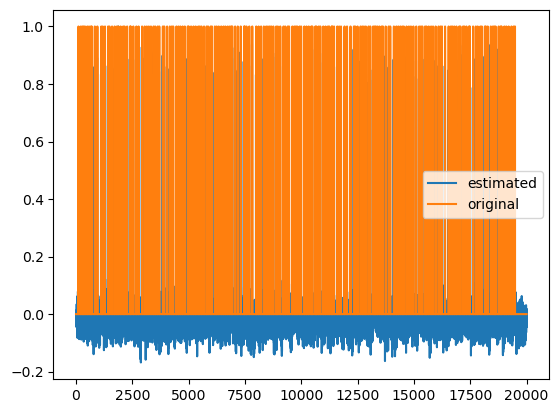

In [22]:
extended_emg = extend_emg(extended_emg, emg, R)
whitened_emg, whitening_mat, dewhitening_mat = whiten_emg(extended_emg)
print('WHITENING EMG...')
# whitened_emg, whitening_mat = pca_whiten(extended_emg)
# whitened_emg = whitening_mat.astype(np.float32) @ extended_emg.astype(np.float32)
# B = get_separation_vectors_avg(extended_emg, spts)
# whitened_emg = extended_emg
B = get_separation_vectors(muaps[:N_mus], R=R)
B = (whitening_mat @ B).T # apply transpose of whitening mtrix to separation vectors, such that we still get spikes from whitened obvs.
mu1 = (B[[0], :] @  whitened_emg).ravel()
plt.figure()
plt.plot(mu1 / mu1.max())
plt.plot(spts[0,:]/spts.max())
plt.legend(['estimated', 'original'])
# plt.savefig('mu')
plt.show()

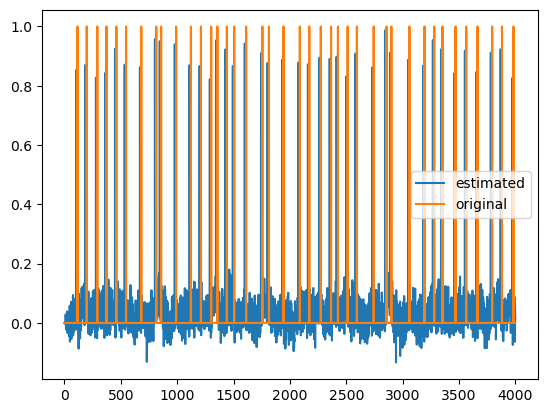

In [23]:
mu1 = (B[[25], :] @  whitened_emg).ravel()
plt.figure()
plt.plot(mu1[0:4000] / mu1.max())
plt.plot(spts[25,:][0:4000]/spts.max())
plt.legend(['estimated', 'original'])
# plt.savefig('mu')
plt.show()